# Quantization Challenge: Making AI Models Smaller and Faster

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/1337-Artificial-Intelligence/hackai-2025/blob/main/new_notebooks/train_quantization.ipynb)

In this notebook, we'll explore quantization techniques for neural networks. You'll learn about:

1. What quantization is and why it's important
2. Different quantization types and data representations
3. How to implement symmetric linear quantization
4. Applying quantization using transformers

Let's get started!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Introduction to Quantization

### What is Quantization?

Quantization is a technique to reduce the computational and memory costs of running neural networks by representing weights and activations with lower-precision data types. Instead of using standard 32-bit floating point (float32), we might use 8-bit or 4-bit integers (int8 or int4) or 16-bit floating point (float16 or bfloat16).

### Benefits of Quantization

- **Reduced memory usage**: Lower precision means smaller model size
- **Lower latency**: Integer operations are faster than floating-point operations
- **Lower power consumption**: Fewer bits mean less energy usage
- **Deployment on edge devices**: Many embedded devices only support integer arithmetic

### Important Concepts

- **Precision**: The number of bits used to represent a value
- **Dynamic range**: The ratio between the largest and smallest representable values
- **Quantization error**: The difference between the original value and its quantized representation
- **Scale and zero-point**: Parameters used to map between floating-point and integer spaces

## 2. Number Representation in Computers

To understand quantization, it helps to know how computers represent numbers. Let's review different data types and their properties.

In [ ]:
!pip3 install numpy torch matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.3 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 68.6 MB 18.5 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 19.5 MB/s eta 0:00:01
     |████████████████████████████████| 134 kB 19.8 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 17.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 194 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 17.4 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 16.4 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 16.9 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 536 kB 15.2 MB/s eta 0:00:01
You should consider upgrad

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import struct

# Setup for displaying figures
%matplotlib inline
plt.style.use('ggplot')

### 2.1 Integer Data Types

Integers can be represented as unsigned (only positive values) or signed (both positive and negative values).

In [ ]:
# Display the range of different integer data types
int_types = {
    'int8': (np.iinfo(np.int8).min, np.iinfo(np.int8).max, 8),
    'uint8': (np.iinfo(np.uint8).min, np.iinfo(np.uint8).max, 8),
    'int16': (np.iinfo(np.int16).min, np.iinfo(np.int16).max, 16),
    'uint16': (np.iinfo(np.uint16).min, np.iinfo(np.uint16).max, 16),
    'int32': (np.iinfo(np.int32).min, np.iinfo(np.int32).max, 32),
    'uint32': (np.iinfo(np.uint32).min, np.iinfo(np.uint32).max, 32)
}

for dtype, (min_val, max_val, bits) in int_types.items():
    print(f"{dtype}: Range [{min_val}, {max_val}], Bits: {bits}, Values: {2**bits}")

int8: Range [-128, 127], Bits: 8, Values: 256
uint8: Range [0, 255], Bits: 8, Values: 256
int16: Range [-32768, 32767], Bits: 16, Values: 65536
uint16: Range [0, 65535], Bits: 16, Values: 65536
int32: Range [-2147483648, 2147483647], Bits: 32, Values: 4294967296
uint32: Range [0, 4294967295], Bits: 32, Values: 4294967296


### 2.2 Floating-Point Data Types

Floating-point numbers have a sign bit, exponent bits, and mantissa (fraction) bits:

In [ ]:
# Display the properties of floating-point data types
float_types = {
    'float16': (np.finfo(np.float16).min, np.finfo(np.float16).max, 16),
    'float32': (np.finfo(np.float32).min, np.finfo(np.float32).max, 32),
    'float64': (np.finfo(np.float64).min, np.finfo(np.float64).max, 64)
}

for dtype, (min_val, max_val, bits) in float_types.items():
    print(f"{dtype}: Range [{min_val}, {max_val}], Bits: {bits}")

# For bfloat16 (not directly available in NumPy)
if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8:  # Ampere or newer
    x = torch.tensor([1.0, -1.0], dtype=torch.bfloat16)
    print(f"bfloat16 example values: {x}")
else:
    print("bfloat16: Range approximately [-3.4e+38, 3.4e+38], Bits: 16 (8 exponent, 7 mantissa)")

float16: Range [-65504.0, 65504.0], Bits: 16
float32: Range [-3.4028234663852886e+38, 3.4028234663852886e+38], Bits: 32
float64: Range [-1.7976931348623157e+308, 1.7976931348623157e+308], Bits: 64
bfloat16: Range approximately [-3.4e+38, 3.4e+38], Bits: 16 (8 exponent, 7 mantissa)


### 2.3 Visual Comparison of Number Representations

Let's visualize how different number formats represent values:

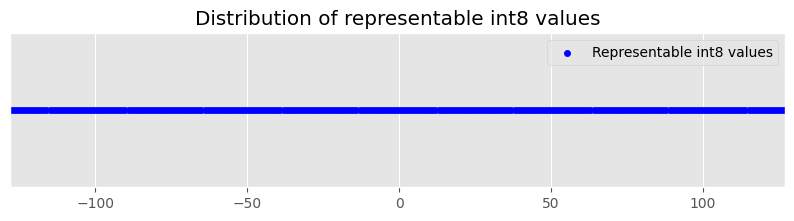

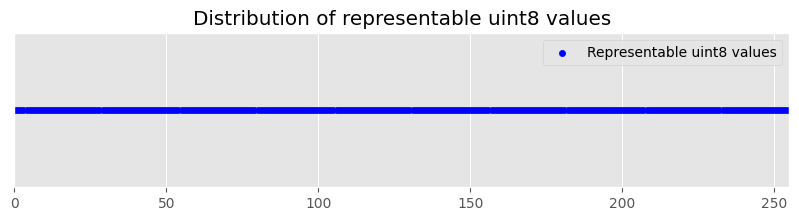

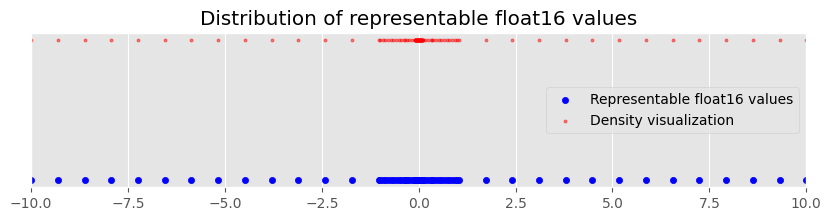

In [ ]:
# Create a simple visualization of the distribution of representable numbers
def visualize_number_line(dtype, num_points=1000):
    if dtype == 'int8':
        values = np.linspace(-128, 127, num_points)
        representable = np.arange(-128, 128)
    elif dtype == 'uint8':
        values = np.linspace(0, 255, num_points)
        representable = np.arange(0, 256)
    elif dtype == 'float16':
        values = np.linspace(-10, 10, num_points)
        # Generate some representable float16 values in different ranges to show distribution
        dense_near_zero = np.array([np.float16(x) for x in np.linspace(-0.1, 0.1, 40)])
        medium_range = np.array([np.float16(x) for x in np.linspace(-1, 1, 30)])
        sparse_range = np.array([np.float16(x) for x in np.linspace(-10, 10, 30)])
        representable = np.concatenate([dense_near_zero, medium_range, sparse_range])
        representable = np.unique(representable)  # Remove duplicates

    plt.figure(figsize=(10, 2))

    # For floating point, show the non-uniform distribution
    if dtype == 'float16':
        plt.scatter(representable, np.zeros_like(representable), color='blue', s=20,
                   label=f'Representable {dtype} values')
        # Add a second row of points with small positive y-value to show density
        point_density = np.ones_like(representable) * 0.1
        plt.scatter(representable, point_density, color='red', s=5, alpha=0.5,
                   label='Density visualization')
    else:
        plt.scatter(representable, np.zeros_like(representable), color='blue', s=20,
                   label=f'Representable {dtype} values')

    plt.xlim([min(values), max(values)])
    plt.title(f'Distribution of representable {dtype} values')
    plt.yticks([])
    plt.legend()
    plt.show()

# Visualize integer and floating-point distributions
visualize_number_line('int8')
visualize_number_line('uint8')
visualize_number_line('float16')

Notice how integers are evenly distributed, while floating-point numbers have higher density near zero and become sparser as the magnitude increases. This is because floating-point formats use some bits for the exponent, allowing them to represent a wider range of values but with varying precision.

## 3. Quantization Types

Quantization is like compressing your model to make it smaller and faster. Let's explore the different ways we can do this:

### 3.1 Based on Precision (What format we're converting to)

1. Float quantization: Converting to smaller floating-point formats
   - Float32 → Float16 (using half the bits - from 32 to 16 bits)
   - Float32 → BFloat16 (a special 16-bit format that's better for training)
   

2. Integer quantization: Converting floating-point numbers to integers
   - Float32 → Int8 (using just 8 bits, or 1/4 of the original size)
   - Float32 → Int4 (using just 4 bits, or 1/8 of the original size)
   

### 3.2 Based on When/How We Determine the Conversion Rules

1. Post-training quantization (PTQ): Apply quantization after the model is fully trained
   
   This is like compressing a finished painting without changing how it was painted.

2. Quantization-aware training (QAT): Train the model while simulating quantization effects
   
   This is like painting while regularly checking how it would look if compressed, adjusting your technique as you go.

### 3.3 Based on How We Map Values (The Math Behind Conversion)

1. Affine quantization: `real_value = scale * (quantized_value - zero_point)`
   - Uses two parameters: scale (S) and zero-point (Z)
   - Zero-point ensures that the real value 0 maps exactly to an integer
   - Like converting temperatures between Fahrenheit and Celsius (needs both multiplication and offset)

2. Symmetric quantization: `real_value = scale * quantized_value`
   - Simpler approach using only scale (S), with zero-point fixed at 0
   - Often maps to [-128, 127] range for int8
   - Like converting between inches and centimeters (just multiplication)

### 3.4 Based on How Detailed the Conversion Rules Are

1. Per-tensor quantization: Use the same conversion rule for the entire tensor
   - Simple and fast, but less precise

2. Per-channel quantization: Use different conversion rules for each channel in the tensor (or dimension)
   - More accurate because different channels often have different value ranges
   - Requires more storage for the extra parameters

## 4. Linear Quantization: Theory

Linear quantization maps a continuous range of values to a discrete set of quantized values. The mapping is defined by two parameters:

- **Scale (S)**: The step size between adjacent representable values
- **Zero-point (Z)**: The quantized value that represents the real value 0. This is crucial when your data isn't balanced around zero (e.g., mostly positive values). Zero-point shifts the quantization range to better match your actual data distribution, ensuring we don't waste precious bits representing values that never occur.

### Quantization Formulas

**Forward quantization** (float → int):
```
x_q = round(x / S + Z)
```

**Dequantization** (int → float):
```
x = S * (x_q - Z)
```

### Computing Scale and Zero-point

For a given range [x_min, x_max] and bit-width n:

**Affine quantization**:
```
S = (x_max - x_min) / (2^n - 1)
Z = round(-x_min / S)
```

**Symmetric quantization**:
```
x_abs_max = max(abs(x_min), abs(x_max))
S = x_abs_max / (2^(n-1) - 1)  # Using n-1 to get range [-2^(n-1), 2^(n-1)-1]
Z = 0
```

Let's implement and visualize these concepts:

In [ ]:
def compute_quantization_params(x_min, x_max, num_bits=8, symmetric=False):
    """Compute scale and zero-point for quantization"""
    if symmetric:
        x_abs_max = max(abs(x_min), abs(x_max))
        # Based on the formulas above, compute the scale
        # 1 line
        zero_point = 0
    else:
        scale = (x_max - x_min) / (2**num_bits - 1)
        # Based on the formulas above, compute the zeropoint
        # 1 line
        zero_point = max(0, min(2**num_bits - 1, zero_point))

    return scale, zero_point

def quantize(x, scale, zero_point, num_bits=8, symmetric=False):
    """Quantize floating-point values to integers"""
    if symmetric:
        # For symmetric, we quantize to [-2^(n-1), 2^(n-1)-1]
        qmin, qmax = -(2**(num_bits-1) - 1), 2**(num_bits-1) - 1
    else:
        # For affine, we quantize to [0, 2^n - 1]
        qmin, qmax = 0, 2**num_bits - 1

    q = np.round(x / scale + zero_point)
    return np.clip(q, qmin, qmax).astype(np.int32)

def dequantize(q, scale, zero_point):
    """Convert quantized values back to floating-point"""
    return scale * (q - zero_point)

Let's visualize how linear quantization maps floating-point values to integers:

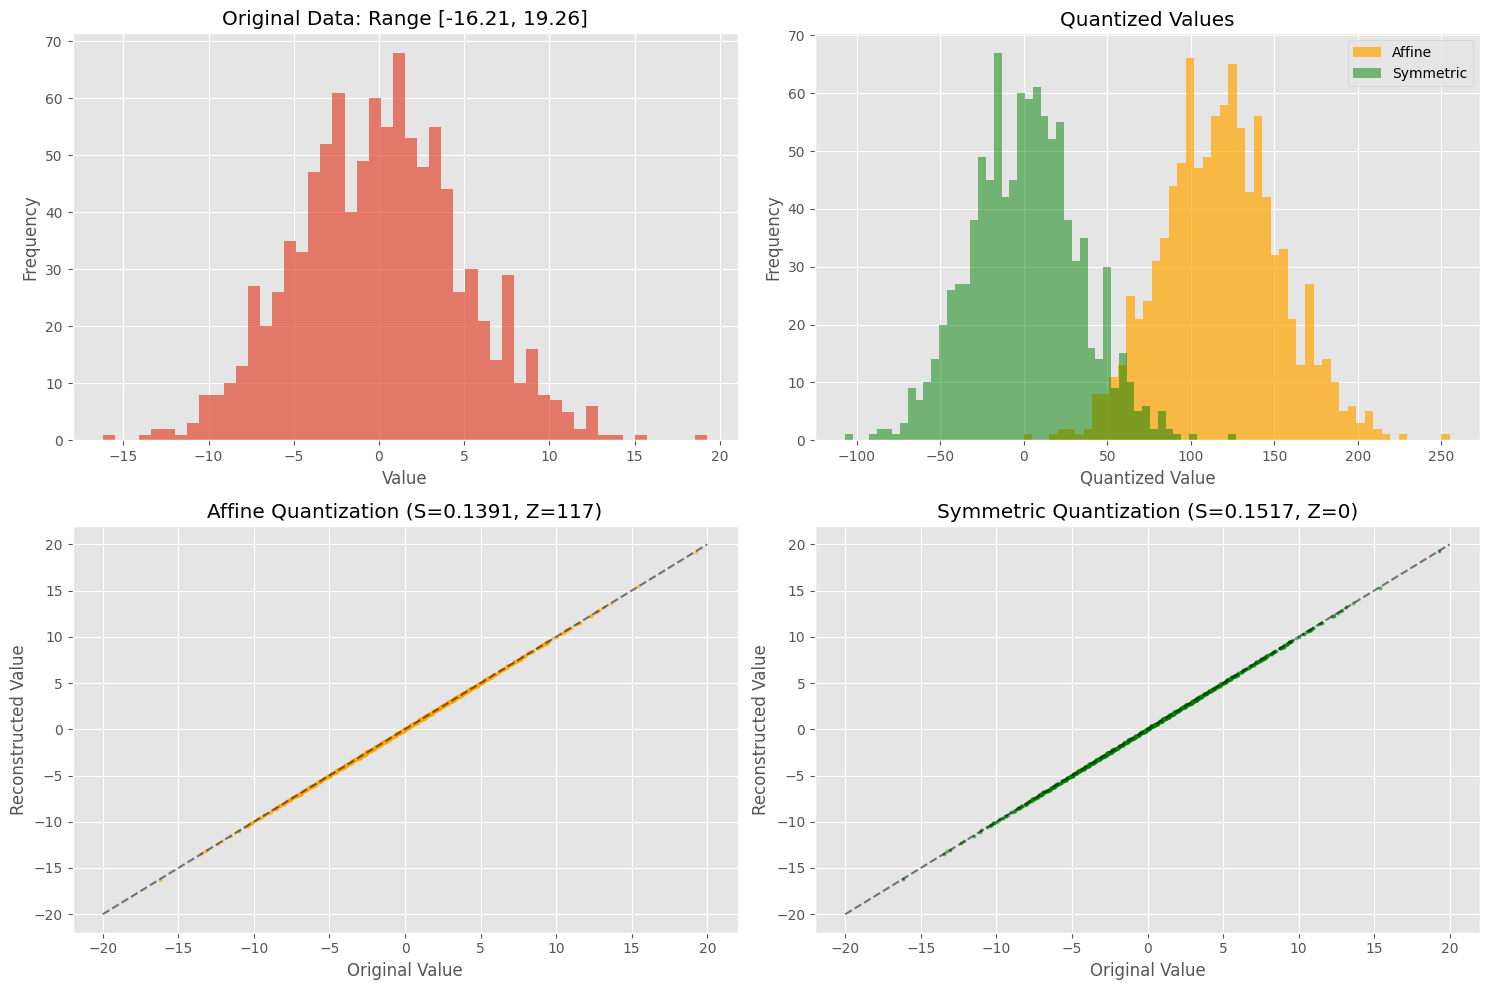

Affine Quantization: Mean Absolute Error = 0.034930
Symmetric Quantization: Mean Absolute Error = 0.037724


In [ ]:
# Generate sample data with a normal distribution
np.random.seed(42)
data = np.random.normal(0, 5, 1000)
x_min, x_max = np.min(data), np.max(data)

# Compute quantization parameters for both methods
scale_affine, zp_affine = compute_quantization_params(x_min, x_max, num_bits=8, symmetric=False)
scale_sym, zp_sym = compute_quantization_params(x_min, x_max, num_bits=8, symmetric=True)

# Quantize and dequantize the data
q_affine = quantize(data, scale_affine, zp_affine, symmetric=False)
q_sym = quantize(data, scale_sym, zp_sym, symmetric=True)

dq_affine = dequantize(q_affine, scale_affine, zp_affine)
dq_sym = dequantize(q_sym, scale_sym, zp_sym)

# Plot the results
plt.figure(figsize=(15, 10))

# Original data distribution
plt.subplot(2, 2, 1)
plt.hist(data, bins=50, alpha=0.7)
plt.title(f'Original Data: Range [{x_min:.2f}, {x_max:.2f}]')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Quantized values distribution
plt.subplot(2, 2, 2)
plt.hist(q_affine, bins=50, alpha=0.7, color='orange', label='Affine')
plt.hist(q_sym, bins=50, alpha=0.5, color='green', label='Symmetric')
plt.title('Quantized Values')
plt.xlabel('Quantized Value')
plt.ylabel('Frequency')
plt.legend()

# Dequantized values
plt.subplot(2, 2, 3)
plt.scatter(data, dq_affine, alpha=0.5, s=5, color='orange')
plt.plot([-20, 20], [-20, 20], 'k--', alpha=0.5)  # perfect reconstruction line
plt.title(f'Affine Quantization (S={scale_affine:.4f}, Z={zp_affine})')
plt.xlabel('Original Value')
plt.ylabel('Reconstructed Value')

plt.subplot(2, 2, 4)
plt.scatter(data, dq_sym, alpha=0.5, s=5, color='green')
plt.plot([-20, 20], [-20, 20], 'k--', alpha=0.5)  # perfect reconstruction line
plt.title(f'Symmetric Quantization (S={scale_sym:.4f}, Z={zp_sym})')
plt.xlabel('Original Value')
plt.ylabel('Reconstructed Value')

plt.tight_layout()
plt.show()

# Calculate quantization error
error_affine = np.abs(data - dq_affine)
error_sym = np.abs(data - dq_sym)

print(f"Affine Quantization: Mean Absolute Error = {np.mean(error_affine):.6f}")
print(f"Symmetric Quantization: Mean Absolute Error = {np.mean(error_sym):.6f}")

Affine quantization error is generally lower than symmetric quantization error, and it's logical because we have more information to work with.

## 5. Implementing Symmetric Linear Quantizer

Now let's implement a simple symmetric linear quantizer function for neural network weights:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SymmetricQuantizer:
    """Implements symmetric linear quantization"""

    def __init__(self, num_bits=8):
        self.num_bits = num_bits
        self.qmin = -(2**(num_bits-1) - 1)
        self.qmax = 2**(num_bits-1) - 1
        self.scale = None

    def get_scale(self, x):
        """Calculate the scale factor for quantization"""
        x_abs_max = torch.max(torch.abs(x))
        scale = x_abs_max / self.qmax
        # Add a small epsilon to avoid division by zero
        scale = torch.max(scale, torch.tensor(1e-8))
        return scale

    def quantize(self, x):
        """Quantize the tensor"""
        # Based on the quantization code above implement this method
        # ~3 lines
        return x_q

    def dequantize(self, x_q):
        """Dequantize the tensor"""
        if self.scale is None:
            raise ValueError("Scale is not set. Quantize first or set scale manually.")
        return x_q * self.scale

    def quantize_dequantize(self, x):
        """Perform quantization followed by dequantization (simulates quantization effects)"""
        x_q = self.quantize(x)
        x_dq = self.dequantize(x_q)
        return x_dq

    def __repr__(self):
        return f"SymmetricQuantizer(bits={self.num_bits}, range=[{self.qmin}, {self.qmax}])"

Let's test our quantizer on some random data:

8-bit: Scale = 0.122110, Mean Abs Error = 0.030619
4-bit: Scale = 2.215433, Mean Abs Error = 0.530928
2-bit: Scale = 15.508031, Mean Abs Error = 3.478832


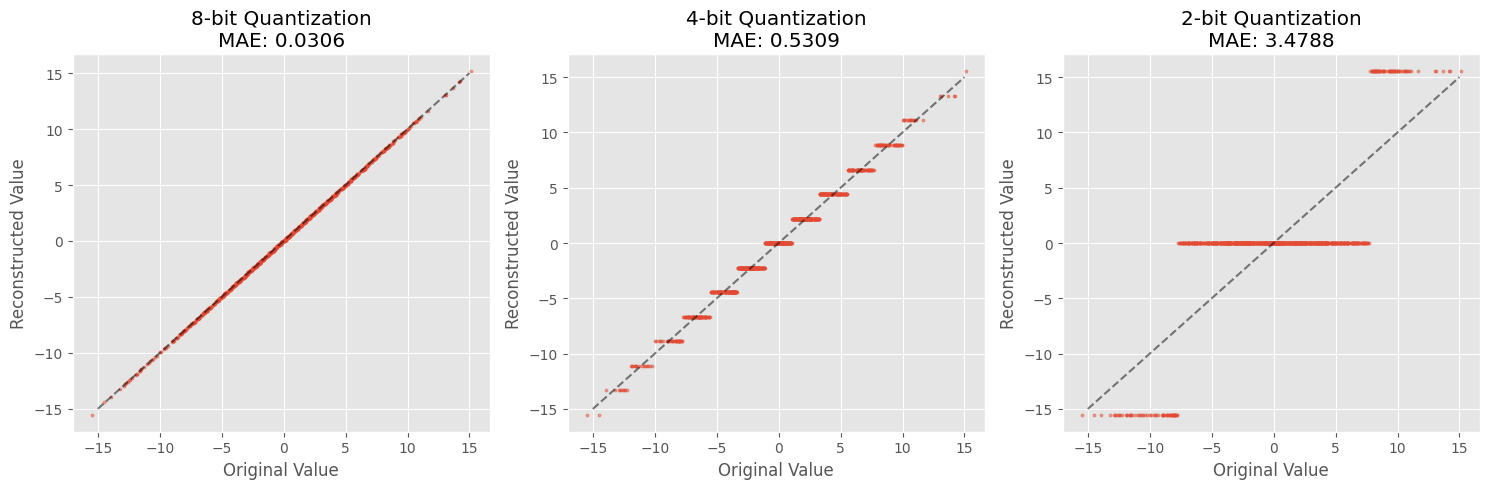

In [ ]:
# Generate random tensor
torch.manual_seed(42)
x = torch.randn(1000) * 5

# Test quantization with different bit widths
bit_widths = [8, 4, 2]
plt.figure(figsize=(15, 5))

for i, bits in enumerate(bit_widths):
    quantizer = SymmetricQuantizer(num_bits=bits)
    x_dq = quantizer.quantize_dequantize(x)

    plt.subplot(1, 3, i+1)
    plt.scatter(x.numpy(), x_dq.numpy(), alpha=0.5, s=5)
    plt.plot([-15, 15], [-15, 15], 'k--', alpha=0.5)  # perfect reconstruction line

    error = torch.abs(x - x_dq).mean().item()
    plt.title(f'{bits}-bit Quantization\nMAE: {error:.4f}')
    plt.xlabel('Original Value')
    plt.ylabel('Reconstructed Value')

    print(f"{bits}-bit: Scale = {quantizer.scale.item():.6f}, Mean Abs Error = {error:.6f}")

plt.tight_layout()
plt.show()

You can see that the more bits we use, the more accurate the quantization is. In the 2-case bits for example we only have 4 values to represent the data, so the quantization is not very accurate.

## 6. Quantization using Transformers

In transformers, we can use different quantization methods very easily using the `HFQuantizer` class under the hood, some of these methods are :

- GPTQ
- AWQ
- BitsAndBytes
- TorchAO
- etc.

Let's see how we can quantize a model using `BitsAndBytes` for example, we need to install `bitsandbytes` and `accelerate`

Note : You need to have a gpu runtime for this section !

In [ ]:
!pip3 install accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 840.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_8bit=True)

quantized_model = AutoModelForCausalLM.from_pretrained(
    "unsloth/Llama-3.2-1B",
    torch_dtype="auto",
    quantization_config=quantization_config
)

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B")
input_text = "What are we having for dinner?"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

output = quantized_model.generate(**input_ids, max_new_tokens=10)
print(tokenizer.decode(output[0], skip_special_tokens=True))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


What are we having for dinner? I don’t know. I’m having a lot


To load a quantized model it's even simpler, and everything is handled internally

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer


quantized_model = AutoModelForCausalLM.from_pretrained(
    "unsloth/Llama-3.2-1B-bnb-4bit",
    torch_dtype="auto",
)

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-bnb-4bit")
input_text = "What are we having for dinner?"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

output = quantized_model.generate(**input_ids, max_new_tokens=10)
print(tokenizer.decode(output[0], skip_special_tokens=True))

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

What are we having for dinner? The answer is: we are having a roast beef


## 7. Challenge Time!

Your challenge is to:
1. Try different bit sizes (8, 4, 2) with our quantizer
2. Compare the results and explain what you see
3. Try quantizing a different model or dataset

Remember:
- More bits = better quality but bigger size
- Fewer bits = smaller size but lower quality
- Choose the right balance for your needs!

## 8. What's Next?

- Try different quantization methods
- Learn about quantization-aware training
- Explore more advanced techniques

Happy Hacking! 🚀